In [1]:
%pip install --quiet --upgrade diffusers transformers scipy ftfy

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --quiet --upgrade accelerate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
from torch import autocast

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers.scheduling_pndm import PNDMScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model definition

In [4]:
class DiffusionPipeline:

    def __init__(self,
                 vae,
                 tokenizer,
                 text_encoder,
                 unet,
                 scheduler):

        self.vae = vae
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler = scheduler
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


    def get_text_embeds(self, text):
        # tokenize the text
        text_input = self.tokenizer(text,
                                    padding='max_length',
                                    max_length=tokenizer.model_max_length,
                                    truncation=True,
                                    return_tensors='pt')
        # embed the text
        with torch.no_grad():
            text_embeds = self.text_encoder(text_input.input_ids.to(self.device))[0]
        return text_embeds


    def get_prompt_embeds(self, prompt):
        if isinstance(prompt, str):
            prompt = [prompt]
        # get conditional prompt embeddings
        cond_embeds = self.get_text_embeds(prompt)
        # get unconditional prompt embeddings
        uncond_embeds = self.get_text_embeds([''] * len(prompt))
        # concatenate the above 2 embeds
        prompt_embeds = torch.cat([uncond_embeds, cond_embeds])
        return prompt_embeds



    def decode_img_latents(self, img_latents):
        img_latents = 1 / self.vae.config.scaling_factor * img_latents
        with torch.no_grad():
            img = self.vae.decode(img_latents).sample

        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.cpu().permute(0, 2, 3, 1).float().numpy()
        return img



    def transform_img(self, img):
        # scale images to the range [0, 255] and convert to int
        img = (img * 255).round().astype('uint8')
        # convert to PIL Image objects
        img = [Image.fromarray(i) for i in img]
        return img


    def encode_img_latents(self, img, latent_timestep):
        if not isinstance(img, list):
            img = [img]

        img = np.stack([np.array(i) for i in img], axis=0)
        # scale images to the range [-1, 1]
        img = 2 * ((img / 255.0) - 0.5)
        img = torch.from_numpy(img).float().permute(0, 3, 1, 2)
        img = img.to(self.device)

        # encode images
        img_latents_dist = self.vae.encode(img)
        img_latents = img_latents_dist.latent_dist.sample()

        # scale images
        img_latents = self.vae.config.scaling_factor * img_latents

        # add noise to the latents
        noise = torch.randn(img_latents.shape).to(self.device)
        img_latents = self.scheduler.add_noise(img_latents, noise, latent_timestep)

        return img_latents


In [5]:
class Depth2ImgPipeline(DiffusionPipeline):
    def __init__(self,
                 vae,
                 tokenizer,
                 text_encoder,
                 unet,
                 scheduler,
                 depth_feature_extractor,
                 depth_estimator):

        super().__init__(vae, tokenizer, text_encoder, unet, scheduler)

        self.depth_feature_extractor = depth_feature_extractor
        self.depth_estimator = depth_estimator


    def get_depth_mask(self, img):
        if not isinstance(img, list):
            img = [img]

        width, height = img[0].size

        # pre-process the input image and get its pixel values
        pixel_values = self.depth_feature_extractor(img, return_tensors="pt").pixel_values

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            depth_mask = self.depth_estimator(pixel_values).predicted_depth

        # get the depth mask
        depth_mask = torch.nn.functional.interpolate(depth_mask.unsqueeze(1),
                                                     size=(height//8, width//8),
                                                     mode='bicubic',
                                                     align_corners=False)

        # scale the mask to range [-1, 1]
        depth_min = torch.amin(depth_mask, dim=[1, 2, 3], keepdim=True)
        depth_max = torch.amax(depth_mask, dim=[1, 2, 3], keepdim=True)
        depth_mask = 2.0 * (depth_mask - depth_min) / (depth_max - depth_min) - 1.0
        depth_mask = depth_mask.to(self.device)

        # replicate the mask for classifier free guidance
        depth_mask = torch.cat([depth_mask] * 2)
        return depth_mask




    def denoise_latents(self,
                        img,
                        prompt_embeds,
                        depth_mask,
                        strength,
                        num_inference_steps=50,
                        guidance_scale=7.5,
                        height=512, width=512):

        # clip the value of strength to ensure strength lies in [0, 1]
        strength = max(min(strength, 1), 0)

        # compute timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        init_timestep = int(num_inference_steps * strength)
        t_start = num_inference_steps - init_timestep

        timesteps = self.scheduler.timesteps[t_start: ]
        num_inference_steps = num_inference_steps - t_start

        latent_timestep = timesteps[:1].repeat(1)

        latents = self.encode_img_latents(img, latent_timestep)

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(timesteps)):
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = torch.cat([latent_model_input, depth_mask], dim=1)

                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)['sample']

                # separate predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

                # perform guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # remove the noise from the current sample i.e. go from x_t to x_{t-1}
                latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']

        return latents


    def __call__(self,
                 prompt,
                 img,
                 strength=0.8,
                 num_inference_steps=50,
                 guidance_scale=7.5,
                 height=512, width=512):


        prompt_embeds = self.get_prompt_embeds(prompt)

        depth_mask = self.get_depth_mask(img)

        latents = self.denoise_latents(img,
                                       prompt_embeds,
                                       depth_mask,
                                       strength,
                                       num_inference_steps,
                                       guidance_scale,
                                       height, width)

        img = self.decode_img_latents(latents)

        img = self.transform_img(img)

        return img


## Create instance of the model

In [6]:
device = 'cuda'

# Load autoencoder
vae = AutoencoderKL.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='vae').to(device)

# Load tokenizer and the text encoder
tokenizer = CLIPTokenizer.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='text_encoder').to(device)

# Load UNet model
unet = UNet2DConditionModel.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='unet').to(device)

# Load scheduler
scheduler = PNDMScheduler(beta_start=0.00085,
                          beta_end=0.012,
                          beta_schedule='scaled_linear',
                          num_train_timesteps=1000)


vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

In [7]:
# Load DPT Depth Estimator
depth_estimator = DPTForDepthEstimation.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='depth_estimator')

# Load DPT Feature Extractor
depth_feature_extractor = DPTFeatureExtractor.from_pretrained('stabilityai/stable-diffusion-2-depth', subfolder='feature_extractor')


depth_estimator/config.json:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


In [8]:
depth2img = Depth2ImgPipeline(vae,
                              tokenizer,
                              text_encoder,
                              unet,
                              scheduler,
                              depth_feature_extractor,
                              depth_estimator)

## Examples

In [9]:
import urllib.parse as parse
import os
import requests

# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False


# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)



In [10]:
import torch
import requests
from PIL import Image
from diffusers import StableDiffusionDepth2ImgPipeline

In [11]:
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16,
).to("cuda")

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Impact of negative prompt example

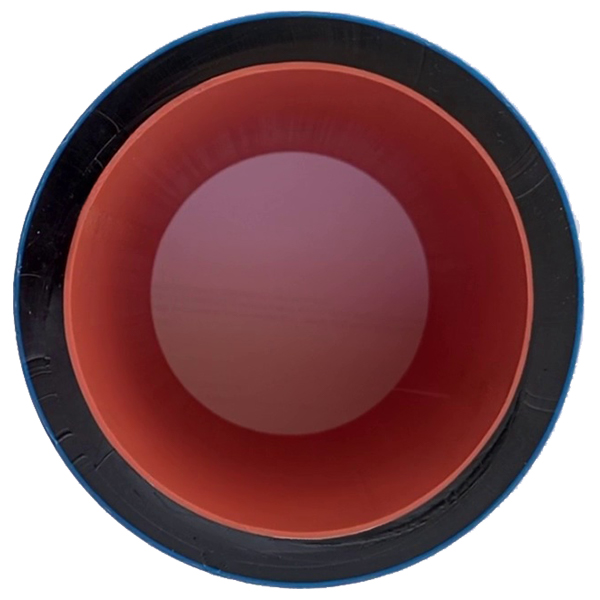

In [48]:
img = load_image("/kaggle/input/original-ok/pipe_ok_1.jpg")
img

In [23]:
os.makedirs("/kaggle/working/def")

  0%|          | 0/3 [00:00<?, ?it/s]

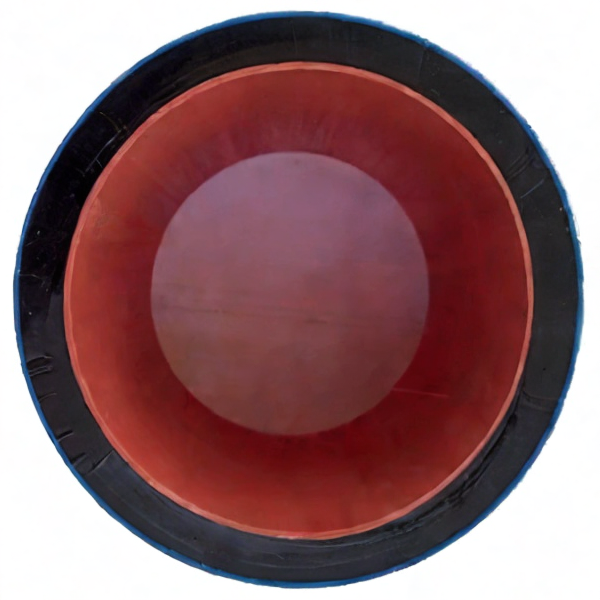

In [88]:
prompt = "save thickness, fine edges, colored accurately, defined edges, high-resolution, high quality, photo realistic"
n_prompt = "blurry, too much blurred, motion blur"
pipe(prompt=prompt, image=img, negative_prompt=n_prompt, strength=0.08).images[0]      

In [ ]:
for i in range(90):
    img = load_image(f"/kaggle/input/original-ok/pipe_ok_{i+1}.jpg")
    prompt = "save thickness, fine edges, colored accurately, defined edges, high-resolution, high quality, photo realistic"
    n_prompt = "blurry, too much blurred, motion blur"
    for j in range(39):
      pipe(prompt=prompt, image=img, negative_prompt=n_prompt, strength=0.08).images[0].save(f"/kaggle/working/def/pipe_ok_{i+1}_{j}.jpg")
    

In [90]:
import tarfile
import os.path

output_filename = 'images_pipes_def.tar.gz'
source_dir = '/kaggle/working/def'

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

In [91]:
make_tarfile(output_filename=output_filename, source_dir=source_dir)

In [ ]:
import shutil

# absolute path
src_path = '/kaggle/working/def/images_pipes_def.tar.gz'
dst_path = '/kaggle/working/images_pipes.tar.gz'
shutil.move(src_path, dst_path)

In [47]:
path = '/kaggle/working/def/'
for file_name in os.listdir(path):
    # construct full file path
    file = path + file_name
    if os.path.isfile(file):        
        os.remove(file)

In [46]:
os.remove('/kaggle/working/images_pipes_def.tar.gz')